In [39]:
import json
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import ttest_rel
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
pio.renderers.default = 'svg'

In [40]:
pd.set_option('display.max_rows', None)

In [41]:
orig_df = pd.read_json('var_results/data_for_modeling.json')
orig_df = orig_df.sort_values(by=['Test set average cross-entropy'])

# Curve fitting

In [42]:
# curve fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def linear(x, a, b):
    return a * x + b

def combine_attrs(list1, list2):
    list1 = list1.tolist()
    list2 = list2.tolist()
    return [str(list1[i]) + ', ' + str(list2[i]) for i in range(len(list1))]

entropy = orig_df['Entropy']
test_set_perplexity = orig_df['Test set perplexity']
test_set_avg_cross_entropy = orig_df['Test set average cross-entropy']
dist = orig_df['Distribution']
uni_or_bi = orig_df['Uni- or bigram']
vocab_size = orig_df['Vocab size']
softmax = orig_df['Softmax']
model_type = orig_df['Model type']
embd_size = orig_df['Embedding size']

x_ent = np.linspace(min(entropy), max(entropy), 100)

ppl_vs_ent = curve_fit(exponential, entropy, test_set_perplexity)

y_ppl = exponential(x_ent, *ppl_vs_ent[0])

ce_vs_ent = curve_fit(linear, entropy, test_set_avg_cross_entropy)

y_ce = linear(x_ent, *ce_vs_ent[0])

ppl_fit = go.Scatter(
    x=x_ent,
    y=y_ppl,
    mode='lines',
    name=f'{ppl_vs_ent[0][0]:.2f} * exp({ppl_vs_ent[0][1]:.2f} * x) + {ppl_vs_ent[0][2]:.2f}'
)

ce_fit = go.Scatter(
    x=x_ent,
    y=y_ce,
    mode='lines',
    name=f'{ce_vs_ent[0][0]:.2f} * x + {ce_vs_ent[0][1]:.2f}'
)

y_equals_x = go.Scatter(
    x=x_ent,
    y=x_ent,
    mode='lines',
    name='Theoretical limit',
    marker=dict(color='red')
)

default_colors = plotly.colors.qualitative.Plotly
next_color = default_colors[13 % len(default_colors)]
ppl_fit.update(marker_color=next_color)
ce_fit.update(marker_color=next_color)
print()

# R^2

In [43]:
residuals = test_set_avg_cross_entropy - linear(np.array(entropy), *ce_vs_ent[0])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((test_set_avg_cross_entropy - np.mean(test_set_avg_cross_entropy))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'Overall R^2: {r_squared}')

Overall R^2: 0.984227875005013


# Plots

In [82]:
legend_dict = dict(
    orientation='h',
    y=-0.15,
)

marker_dict = dict(
    size=6,
    opacity=0.8,
)

layout = go.Layout(
    margin = go.layout.Margin(
        b=20,
        t=50,
    )
)

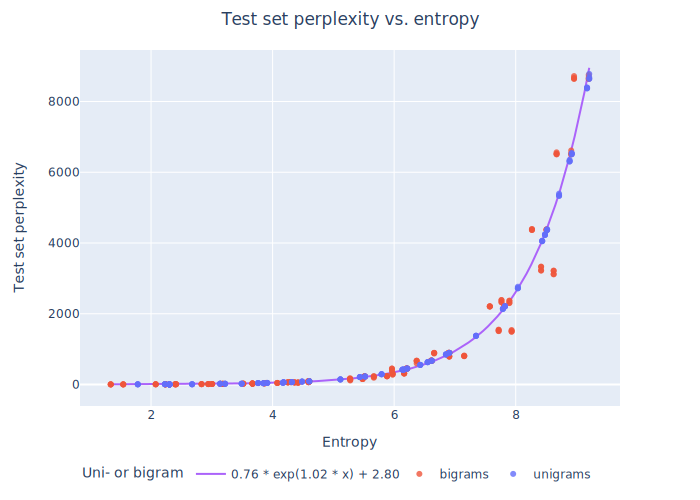

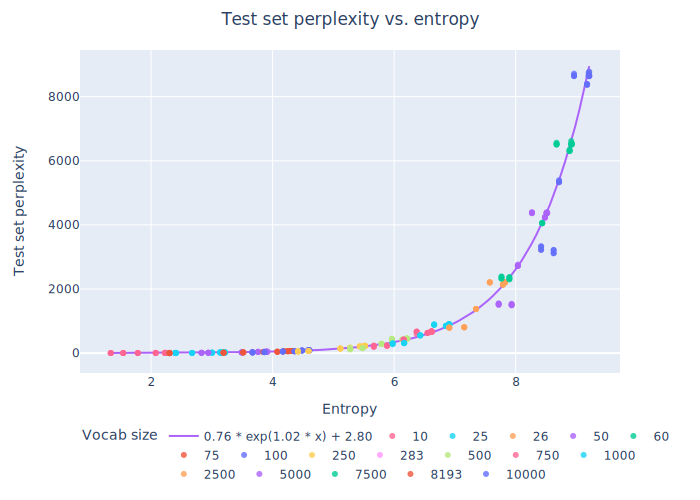

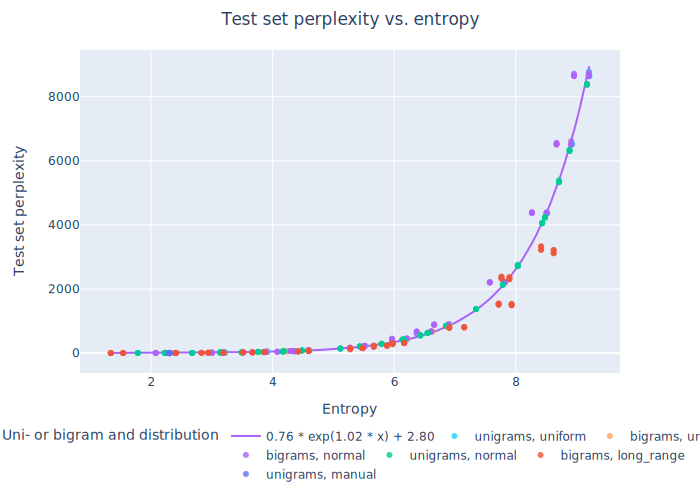

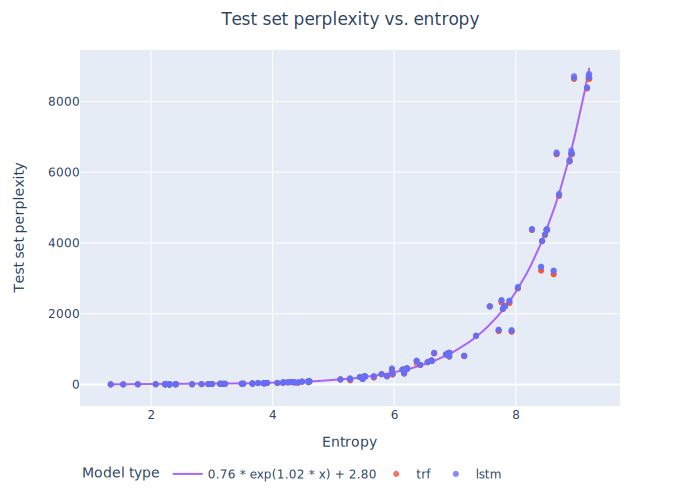

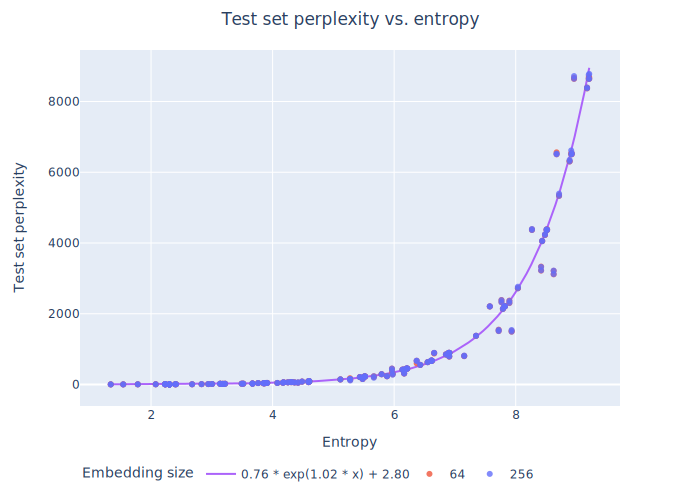

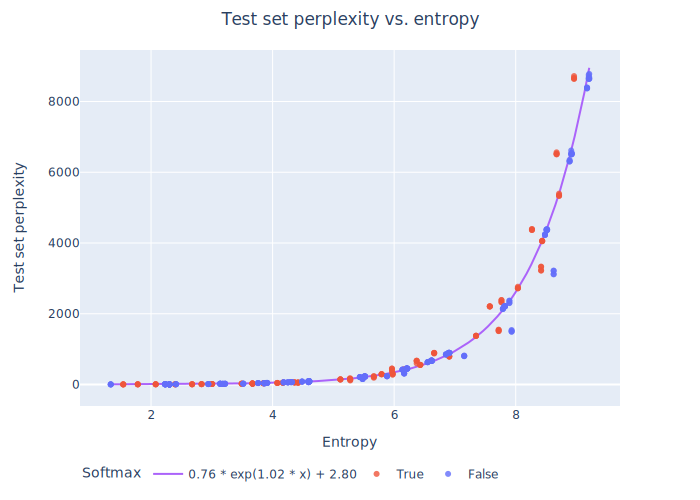

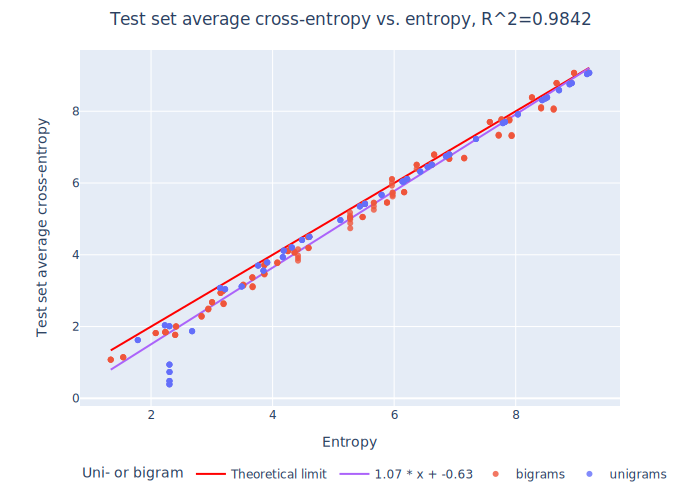

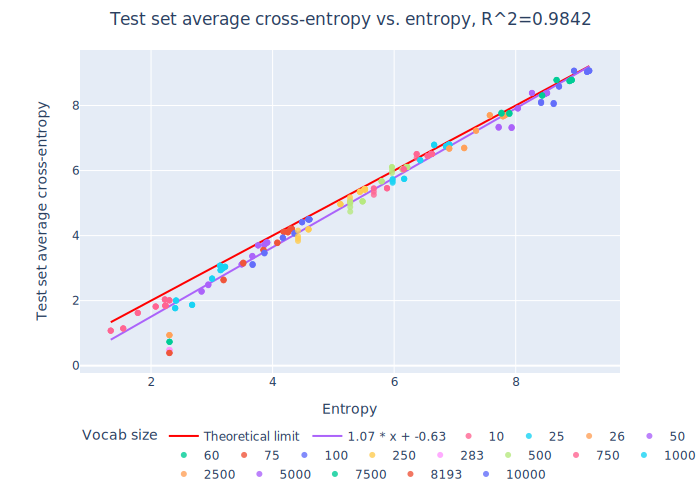

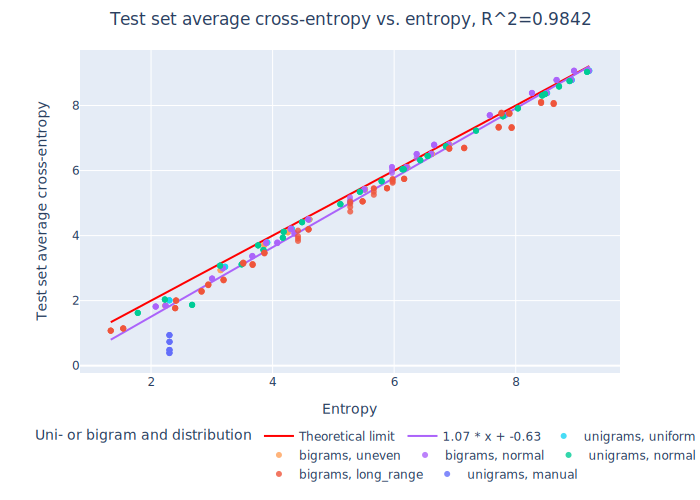

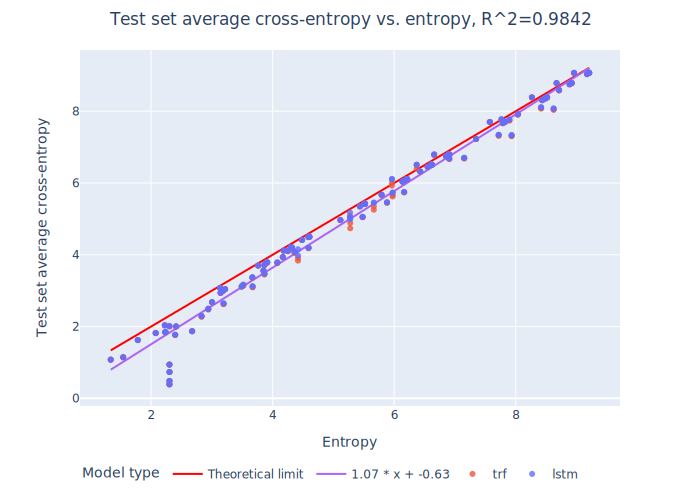

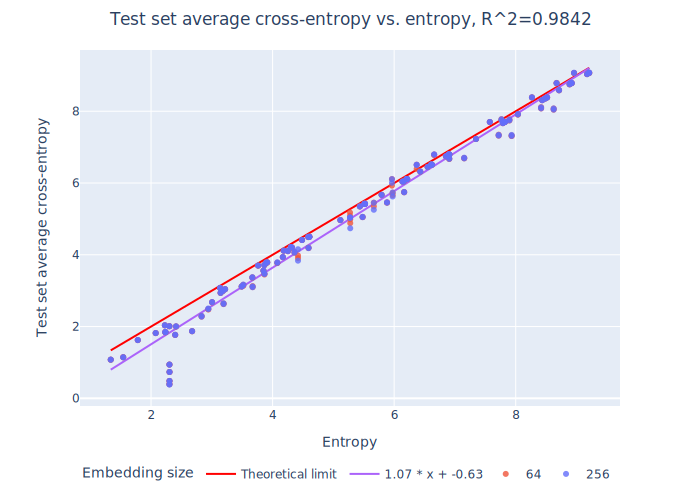

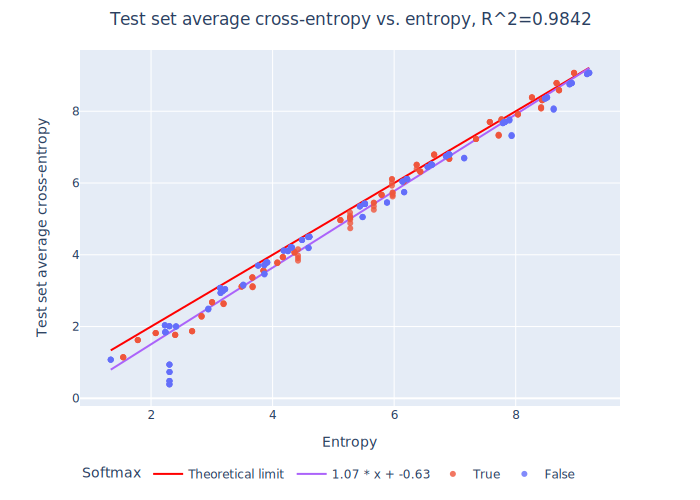

In [83]:
fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Uni- or bigram'},
    color=uni_or_bi,
    hover_data={'Vocab size': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)

fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi.html')
pio.write_image(fig, 'plots/uni_or_bi.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Vocab size'},
    color=[str(x) for x in vocab_size],
    category_orders={'color': reversed([str(x) for x in sorted(vocab_size)])},
    hover_data={'Uni- or bigram': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/vocab.html')
pio.write_image(fig, 'plots/vocab.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Uni- or bigram and distribution'},
    color=combine_attrs(uni_or_bi, dist),
    hover_data={'Vocab size': True, 'Softmax': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_dist.html')
pio.write_image(fig, 'plots/uni_or_bi_dist.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Model type'},
    color='Model type',
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/model_type.html')
pio.write_image(fig, 'plots/model_type.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Embedding size'},
    color=[str(x) for x in embd_size],
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/embd_size.html')
pio.write_image(fig, 'plots/embd_size.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Softmax'},
    color='Softmax',
    hover_data={'Vocab size': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/softmax.html')
pio.write_image(fig, 'plots/softmax.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Uni- or bigram'},
    color='Uni- or bigram',
    hover_data={'Vocab size': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_ce.html')
pio.write_image(fig, 'plots/uni_or_bi_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Vocab size'},
    color=[str(x) for x in vocab_size],
    category_orders={'color': reversed([str(x) for x in sorted(vocab_size)])},
    hover_data={'Uni- or bigram': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/vocab_ce.html')
pio.write_image(fig, 'plots/vocab_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Uni- or bigram and distribution'},
    color=combine_attrs(uni_or_bi, dist),
    hover_data={'Vocab size': True, 'Softmax': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_dist_ce.html')
pio.write_image(fig, 'plots/uni_or_bi_dist_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Model type'},
    color='Model type',
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/model_type_ce.html')
pio.write_image(fig, 'plots/model_type_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Embedding size'},
    color=[str(x) for x in embd_size],
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/embd_size_ce.html')
pio.write_image(fig, 'plots/embd_size_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Softmax'},
    color='Softmax',
    hover_data={'Vocab size': True, 'Embedding size': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict, margin=layout.margin, title_x=0.5)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/softmax_ce.html')
pio.write_image(fig, 'plots/softmax_ce.pdf')
fig.show()

# Linear models

In [46]:
def encode_and_fit(df_arg):
    
    df = df_arg.copy()
    
    enc = OrdinalEncoder()
    scaler = StandardScaler()
    try:
        df['Distribution'] = enc.fit_transform(df[['Distribution']])
    except:
        pass
    try:
        df['Uni- or bigram'] = enc.fit_transform(df[['Uni- or bigram']])
    except:
        pass
    try:
        df['Softmax'] = enc.fit_transform(df[['Softmax']])
    except:
        pass
    try:
        df['Model type'] = enc.fit_transform(df[['Model type']])
    except:
        pass
    for col in df.columns:
        if col not in ['Distribution', 'Uni- or bigram', 'Softmax', 'Model type', 'Test set perplexity']:
            df[col] = scaler.fit_transform(df[[col]])
    
    reg = sm.OLS(
        df['Test set average cross-entropy'],
        sm.add_constant(df.drop(columns=['Test set average cross-entropy', 'Test set perplexity']))
    )
    res = reg.fit()
    # print(res.summary2())
    # print('\n\n\n')
    # print(f'{res.rsquared:.4f}\n')
    return res

In [47]:
# all variables, all data
print('All variables, all data')
encode_and_fit(orig_df)

All variables, all data


In [48]:
for var in ['Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']:
    print('independent variable:', var)
    df_to_fit = orig_df[[var, 'Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)

independent variable: Entropy
independent variable: Distribution
independent variable: Uni- or bigram
independent variable: Vocab size
independent variable: Softmax
independent variable: Model type
independent variable: Embedding size


# Single features on subsets

In [49]:
vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

single_feature_subsets_df = pd.DataFrame(columns=['All'] + vars)
index = [f'{var}={unique_val}' for var in vars for unique_val in orig_df[var].unique()]
# insert enough rows for the index
for i in range(len(index)):
    single_feature_subsets_df.loc[i] = 0
single_feature_subsets_df.index = index

for var in vars:
    for unique_val in orig_df[var].unique():
        for other_var in ['Entropy'] + vars:
            df_to_fit = orig_df[orig_df[var] == unique_val]
            if len(df_to_fit) <= 4:
                continue
            # print('data subset:', var, '=', unique_val)
            # print('feature:', other_var)
            res = encode_and_fit(df_to_fit[[other_var, 'Test set average cross-entropy', 'Test set perplexity']])
            single_feature_subsets_df.loc[f'{var}={unique_val}', other_var] = res.rsquared
        # use all variables
        res = encode_and_fit(df_to_fit)
        single_feature_subsets_df.loc[f'{var}={unique_val}', 'All'] = res.rsquared

In [50]:
nu_df = pd.DataFrame(columns=['All'] + vars)
for other_var in ['Entropy'] + vars:
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'unigrams']
    if len(df_to_fit) <= 4:
        continue
    # print('data subset:', var, '=', unique_val)
    # print('feature:', other_var)
    res = encode_and_fit(df_to_fit[[other_var, 'Test set average cross-entropy', 'Test set perplexity']])
    nu_df.loc[f'{var}={unique_val}', other_var] = res.rsquared
# use all variables
res = encode_and_fit(df_to_fit)
nu_df.loc[f'{var}={unique_val}', 'All'] = res.rsquared

nb_df = pd.DataFrame(columns=['All'] + vars)
for other_var in ['Entropy'] + vars:
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'bigrams']
    if len(df_to_fit) <= 4:
        continue
    # print('data subset:', var, '=', unique_val)
    # print('feature:', other_var)
    res = encode_and_fit(df_to_fit[[other_var, 'Test set average cross-entropy', 'Test set perplexity']])
    nb_df.loc[f'{var}={unique_val}', other_var] = res.rsquared
# use all variables
res = encode_and_fit(df_to_fit)
nb_df.loc[f'{var}={unique_val}', 'All'] = res.rsquared

In [51]:
nb_df[['All', 'Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']]

,All,Entropy,Distribution,Uni- or bigram,Vocab size,Softmax,Model type,Embedding size
Embedding size=64,0.998,0.997,0.000,0.000,0.636,0.001,0.000,0.000


In [52]:
# display floats in pandas as rounded to 3 decimal places, no scientific notation
pd.options.display.float_format = '{:.3f}'.format

# sort rows by the index
single_feature_subsets_df = single_feature_subsets_df.sort_index()
# manually re-order columns
single_feature_subsets_df = single_feature_subsets_df[[
    'All', 'Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size'
]]

print(single_feature_subsets_df)

                          All  Entropy  Distribution  Uni- or bigram  \
Distribution=long_range 0.996    0.996         0.000           0.000   
Distribution=manual     0.633    0.000         0.000           0.000   
Distribution=normal     0.997    0.997         0.000           0.002   
Distribution=uneven     1.000    0.999         0.000           0.000   
Distribution=uniform    1.000    1.000         0.000           0.000   
Embedding size=256      0.990    0.984         0.031           0.000   
Embedding size=64       0.990    0.984         0.030           0.000   
Model type=lstm         0.990    0.984         0.030           0.000   
Model type=trf          0.990    0.984         0.031           0.000   
Softmax=False           0.987    0.979         0.039           0.000   
Softmax=True            0.997    0.995         0.028           0.001   
Uni- or bigram=bigrams  0.996    0.993         0.005           0.000   
Uni- or bigram=unigrams 0.989    0.976         0.168          -0

In [53]:
# just vocab size rows
print('Vocab size rows')
vocab_size_rows = single_feature_subsets_df.loc[[f'Vocab size={x}' for x in orig_df['Vocab size'].unique()]]

# sort by integer value following equal sign
vocab_size_rows = vocab_size_rows.reindex(sorted(vocab_size_rows.index, key=lambda x: int(x.split('=')[1])))

# drop 26, 60, 283, 8193
vocab_size_rows = vocab_size_rows.drop('Vocab size=26')
vocab_size_rows = vocab_size_rows.drop('Vocab size=60')
vocab_size_rows = vocab_size_rows.drop('Vocab size=283')
vocab_size_rows = vocab_size_rows.drop('Vocab size=8193')

print(vocab_size_rows)

Vocab size rows
                   All  Entropy  Distribution  Uni- or bigram  Vocab size  \
Vocab size=10    0.977    0.937         0.586           0.230      -0.000   
Vocab size=25    0.972    0.919         0.471           0.029       0.000   
Vocab size=50    0.997    0.988         0.605           0.124       0.000   
Vocab size=75    1.000    0.990         0.571           0.120       0.000   
Vocab size=100   0.998    0.990         0.605           0.119       0.000   
Vocab size=250   0.993    0.990         0.594           0.144       0.000   
Vocab size=500   0.988    0.948         0.560           0.093       0.000   
Vocab size=750   0.992    0.938         0.553           0.079       0.000   
Vocab size=1000  0.994    0.934         0.546           0.074       0.000   
Vocab size=2500  0.996    0.904         0.713           0.145      -0.000   
Vocab size=5000  1.000    0.862         0.716           0.151       0.000   
Vocab size=7500  0.991    0.960         0.711           0.14

# Feature exclusion

In [54]:
# model all the data
print('Model all the data')

vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

for excluded_var in ['Entropy'] + vars:
    independent_vars = ['Entropy'] + vars.copy()
    independent_vars.remove(excluded_var)
    df_to_fit = orig_df[independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)
    print(f'Excluding {excluded_var}: {res.rsquared:.3f}')

Model all the data
Excluding Entropy: 0.544
Excluding Distribution: 0.988
Excluding Uni- or bigram: 0.989
Excluding Vocab size: 0.989
Excluding Softmax: 0.990
Excluding Model type: 0.990
Excluding Embedding size: 0.990


In [55]:
vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

excluded_df = pd.DataFrame(columns=['Entropy'] + vars)
index = [f'{var}={unique_val}' for var in vars for unique_val in orig_df[var].unique()]
# insert enough rows for the index
for i in range(len(index)):
    excluded_df.loc[i] = 0
excluded_df.index = index

for var in vars:
    for unique_val in orig_df[var].unique():
        for excluded_var in ['Entropy'] + vars:
            independent_vars = ['Entropy'] + vars.copy()
            independent_vars.remove(excluded_var)
            df_to_fit = orig_df[orig_df[var] == unique_val][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
            if len(df_to_fit) <= 4:
                continue
            res = encode_and_fit(df_to_fit)
            excluded_df.loc[f'{var}={unique_val}', excluded_var] = res.rsquared
            
# drop vocab size 8193, 283, 60, 26
excluded_df = excluded_df.drop('Vocab size=26')
excluded_df = excluded_df.drop('Vocab size=60')
excluded_df = excluded_df.drop('Vocab size=283')
excluded_df = excluded_df.drop('Vocab size=8193')

In [56]:
excluded_nu_df = pd.DataFrame(columns=['Entropy'] + vars)

for excluded_var in ['Entropy'] + vars:
    independent_vars = ['Entropy'] + vars.copy()
    independent_vars.remove(excluded_var)
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'unigrams'][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)
    excluded_nu_df.loc[f'normal, unigrams', excluded_var] = res.rsquared
    
excluded_nb_df = pd.DataFrame(columns=['Entropy'] + vars)

for excluded_var in ['Entropy'] + vars:
    independent_vars = ['Entropy'] + vars.copy()
    independent_vars.remove(excluded_var)
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'bigrams'][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)
    excluded_nb_df.loc[f'normal, bigrams', excluded_var] = res.rsquared
    
print(excluded_nu_df)
print(excluded_nb_df)

                 Entropy Distribution Uni- or bigram Vocab size Softmax  \
normal, unigrams   0.643        0.997          0.997      0.997   0.997   

                 Model type Embedding size  
normal, unigrams      0.997          0.997  
                Entropy Distribution Uni- or bigram Vocab size Softmax  \
normal, bigrams   0.637        0.998          0.998      0.998   0.998   

                Model type Embedding size  
normal, bigrams      0.998          0.998  


In [57]:
excluded_df

,Entropy,Distribution,Uni- or bigram,Vocab size,Softmax,Model type,Embedding size
Distribution=manual,0.462,0.633,0.633,0.000,0.633,0.633,0.633
Distribution=long_range,0.660,0.996,0.996,0.996,0.996,0.996,0.996
Distribution=normal,0.639,0.997,0.997,0.997,0.997,0.997,0.997
Distribution=uneven,0.762,1.000,1.000,0.999,1.000,1.000,1.000
Distribution=uniform,0.643,1.000,1.000,1.000,1.000,1.000,1.000
Uni- or bigram=unigrams,0.558,0.984,0.989,0.986,0.988,0.989,0.989
Uni- or bigram=bigrams,0.621,0.994,0.996,0.996,0.996,0.996,0.996
Vocab size=10,0.612,0.975,0.939,0.977,0.977,0.977,0.977
Vocab size=25,0.652,0.967,0.970,0.972,0.932,0.972,0.972
Vocab size=50,0.650,0.996,0.996,0.997,0.988,0.997,0.997


# Pearson and Spearman rhos

In [58]:
orig_df.corr(method='pearson')

,Test set perplexity,Test set average cross-entropy,Entropy,Vocab size,Softmax,Embedding size
Test set perplexity,1.000,0.738,0.755,0.885,-0.012,0.001
Test set average cross-entropy,0.738,1.000,0.992,0.691,0.015,0.000
Entropy,0.755,0.992,1.000,0.734,0.004,-0.000
Vocab size,0.885,0.691,0.734,1.000,0.040,-0.000
Softmax,-0.012,0.015,0.004,0.040,1.000,-0.000
Embedding size,0.001,0.000,-0.000,-0.000,-0.000,1.000


In [59]:
orig_df.corr(method='spearman')

,Test set perplexity,Test set average cross-entropy,Entropy,Vocab size,Softmax,Embedding size
Test set perplexity,1.000,1.000,0.995,0.909,0.002,0.004
Test set average cross-entropy,1.000,1.000,0.995,0.909,0.002,0.004
Entropy,0.995,0.995,1.000,0.930,-0.008,0.000
Vocab size,0.909,0.909,0.930,1.000,0.042,0.000
Softmax,0.002,0.002,-0.008,0.042,1.000,0.000
Embedding size,0.004,0.004,0.000,0.000,0.000,1.000


In [60]:
orig_df['Entropy'].describe()

count   416.000
mean      5.444
std       2.214
min       1.337
25%       3.670
50%       5.515
75%       7.202
max       9.210
Name: Entropy, dtype: float64

In [61]:
enc = OrdinalEncoder()

pearsons = []
spearmans = []

for v in orig_df['Vocab size'].unique():
    subset = orig_df[orig_df['Vocab size'] == v].copy()
    subset['Distribution'] = enc.fit_transform(subset[['Distribution']])
    if v in (8193, 283, 60, 26):
        continue
    print(v, f'dist count = {len(subset["Distribution"].unique())}')
    pearsons.append(subset[['Entropy', 'Distribution']].corr(method='pearson').iloc[0, 1])
    spearmans.append(subset[['Entropy', 'Distribution']].corr(method='spearman').iloc[0, 1])
    
print(sum(pearsons) / len(pearsons))
print(sum(spearmans) / len(spearmans))

10 dist count = 4
25 dist count = 4
50 dist count = 4
75 dist count = 4
100 dist count = 4
250 dist count = 4
500 dist count = 4
750 dist count = 4
1000 dist count = 4
2500 dist count = 3
5000 dist count = 3
7500 dist count = 3
10000 dist count = 3
0.7974295415829366
0.9015635559620017


# Mixed Effects

In [62]:
formula = "Q('Test set average cross-entropy') ~ Q('Distribution') + Q('Uni- or bigram') + Q('Vocab size') + Q('Softmax') + Q('Model type') + Q('Embedding size') - 1"

In [63]:
model = smf.mixedlm(
    formula,
    data=orig_df,
    groups=orig_df['Entropy']
).fit()
print(model.summary())

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Test set average cross-entropy')
No. Observations: 416     Method:             REML                               
No. Groups:       104     Scale:              0.0006                             
Min. group size:  4       Log-Likelihood:     440.2298                           
Max. group size:  4       Converged:          Yes                                
Mean group size:  4.0                                                            
----------------------------------------------------------------------------------
                                   Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------
Q('Distribution')[long_range]       3.726     0.340  10.963  0.000   3.060   4.392
Q('Distribution')[manual]          -0.309     0.827  -0.374  0.708  -1.930   1.311
Q('Distribution')[normal]        

In [64]:
x = orig_df['Entropy']
y = orig_df['Test set average cross-entropy']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
orig_df['Entropy residual'] = model.resid

formula = "Q('Entropy residual') ~ Q('Distribution') + Q('Uni- or bigram') + Q('Vocab size') + Q('Softmax') + Q('Model type') + Q('Embedding size') - 1"

model = smf.mixedlm(
    formula,
    data=orig_df,
    groups=orig_df['Entropy']
).fit()
print(model.summary())

                   Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   Q('Entropy residual')
No. Observations:     416       Method:               REML                 
No. Groups:           104       Scale:                0.0006               
Min. group size:      4         Log-Likelihood:       671.2819             
Max. group size:      4         Converged:            Yes                  
Mean group size:      4.0                                                  
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Q('Distribution')[long_range]   -0.058    0.031  -1.874 0.061 -0.118  0.003
Q('Distribution')[manual]       -1.077    0.075 -14.452 0.000 -1.223 -0.931
Q('Distribution')[normal]        0.189    0.031   6.148 0.000  0.129  0.249
Q('Distribution')[uneven]      

# Paired test - effect of long-range dependencies

In [65]:
normal_bigrams = orig_df[orig_df['Uni- or bigram'] == 'bigrams']
normal_bigrams = normal_bigrams[normal_bigrams['Distribution'] == 'normal']
normal_bigrams = normal_bigrams.sort_values(by=['Vocab size', 'Softmax', 'Model type', 'Embedding size']).reset_index(drop=True)
normal_bigrams = normal_bigrams[['Test set average cross-entropy', 'Entropy', 'Distribution']]
normal_bigrams = normal_bigrams.rename(columns={'Test set average cross-entropy': 'ce', 'Entropy': 'ent', 'Distribution': 'dist'})
normal_bigrams['pair_idx'] = normal_bigrams.index
normal_bigrams.shape, normal_bigrams.head()

((104, 4),
      ce   ent    dist  pair_idx
 0 1.841 2.239  normal         0
 1 1.841 2.239  normal         1
 2 1.843 2.239  normal         2
 3 1.845 2.239  normal         3
 4 1.819 2.077  normal         4)

In [66]:
long_range_bigrams = orig_df[orig_df['Uni- or bigram'] == 'bigrams']
long_range_bigrams = long_range_bigrams[long_range_bigrams['Distribution'] == 'long_range']
long_range_bigrams = long_range_bigrams.sort_values(by=['Vocab size', 'Softmax', 'Model type', 'Embedding size']).reset_index(drop=True)
long_range_bigrams = long_range_bigrams[['Test set average cross-entropy', 'Entropy', 'Distribution']]
long_range_bigrams = long_range_bigrams.rename(columns={'Test set average cross-entropy': 'ce', 'Entropy': 'ent', 'Distribution': 'dist'})
long_range_bigrams['pair_idx'] = long_range_bigrams.index
long_range_bigrams.shape, long_range_bigrams.head()

((104, 4),
      ce   ent        dist  pair_idx
 0 1.078 1.337  long_range         0
 1 1.078 1.337  long_range         1
 2 1.075 1.337  long_range         2
 3 1.077 1.337  long_range         3
 4 1.148 1.542  long_range         4)

In [67]:
paired_test_df = pd.concat([normal_bigrams, long_range_bigrams], axis=0)
paired_test_df['deviation'] = paired_test_df['ent'] - paired_test_df['ce']
paired_test_df['dist'] = pd.Categorical(paired_test_df['dist'], categories=['normal', 'long_range'], ordered=True)
paired_test_df.shape, paired_test_df.head()

((208, 5),
      ce   ent    dist  pair_idx  deviation
 0 1.841 2.239  normal         0      0.398
 1 1.841 2.239  normal         1      0.398
 2 1.843 2.239  normal         2      0.396
 3 1.845 2.239  normal         3      0.394
 4 1.819 2.077  normal         4      0.258)

In [68]:
model = smf.mixedlm(
    "deviation ~ dist",
    data=paired_test_df,
    groups=paired_test_df['pair_idx']
)
res = model.fit()
print(res.summary())

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  deviation
No. Observations:    208      Method:              REML     
No. Groups:          104      Scale:               0.0106   
Min. group size:     2        Log-Likelihood:      109.3966 
Max. group size:     2        Converged:           Yes      
Mean group size:     2.0                                    
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.102    0.015  6.899 0.000  0.073  0.131
dist[T.long_range] 0.296    0.014 20.704 0.000  0.268  0.324
Group Var          0.012    0.034                           



In [69]:
normal_bigrams['deviation'] = normal_bigrams['ent'] - normal_bigrams['ce']
normal_bigrams.shape, normal_bigrams.head()

((104, 5),
      ce   ent    dist  pair_idx  deviation
 0 1.841 2.239  normal         0      0.398
 1 1.841 2.239  normal         1      0.398
 2 1.843 2.239  normal         2      0.396
 3 1.845 2.239  normal         3      0.394
 4 1.819 2.077  normal         4      0.258)

In [70]:
long_range_bigrams['deviation'] = long_range_bigrams['ent'] - long_range_bigrams['ce']
long_range_bigrams.shape, long_range_bigrams.head()

((104, 5),
      ce   ent        dist  pair_idx  deviation
 0 1.078 1.337  long_range         0      0.259
 1 1.078 1.337  long_range         1      0.259
 2 1.075 1.337  long_range         2      0.262
 3 1.077 1.337  long_range         3      0.260
 4 1.148 1.542  long_range         4      0.394)

In [71]:
ttest_rel(
    normal_bigrams['deviation'],
    long_range_bigrams['deviation']
)

Ttest_relResult(statistic=-20.704150217101013, pvalue=1.7026635595139926e-38)

# Heatmaps to show dists

In [72]:
fnames_100_nosoftmax = glob.glob('var_results/*_50_nosoftmax.json')
fnames_100_softmax = glob.glob('var_results/*_50_softmax.json')
jsons_100_nosoftmax = [
    json.load(open(f)) for f in fnames_100_nosoftmax
]
jsons_100_softmax = [
    json.load(open(f)) for f in fnames_100_softmax
]

manual = 'var_results/manual_unigrams_60_nosoftmax_manual_0.6.json'
manual_json = json.load(open(manual))

fnames = fnames_100_nosoftmax + fnames_100_softmax + [manual]
tables = [j['table'] for j in jsons_100_nosoftmax] + [j['table'] for j in jsons_100_softmax] + [manual_json['table']]
entropies = [j['entropy'] for j in jsons_100_nosoftmax] + [j['entropy'] for j in jsons_100_softmax] + [manual_json['entropy']]

del jsons_100_nosoftmax
del jsons_100_softmax

In [73]:
fnames[0]

'var_results/long_range_bigrams_50_nosoftmax.json'

In [74]:
def plot_heatmap(fname, data, entropy):
    save_name = fname.split('/')[-1].replace('.json', '.png')
    title = fname.split('/')[-1].replace('.json', '').replace('_50_', ', ').replace(', nosoftmax', '').replace('_', ' ')
    title = title[0].upper() + title[1:]
    title += f', entropy={entropy:.4f}'
    if 'manual' in title:
        title = f'Manual unigrams, entropy={entropy:.4f}'
    # plt.figure()
    # sns.heatmap(data, cmap='coolwarm', square=True)
    # plt.title(title)
    # plt.savefig('heatmaps/' + save_name)
    # plt.show()
    # plt.close()
    layout = go.Layout(
        margin = go.layout.Margin(
            l=5,
            r=5,
            b=20,
            t=50,
        )
    )
    if 'unigram' in title:
        fig = px.imshow(
            data,
            title=title,
            color_continuous_scale='RdBu_r',
            width = 500,
            height = 200
        )
        fig.update_yaxes(showticklabels=False)
    else:
        fig = px.imshow(
            data,
            title=title,
            color_continuous_scale='RdBu_r',
            width = 500,
            height = 400
        )
    fig.update_traces(
        dict(
            showscale=False
        )
    )
    fig.update_layout(layout, title_x=0.5)
    fig.show()
    fig.write_html('heatmaps/' + save_name.replace('.png', '.html'))
    pio.write_image(fig, 'heatmaps/' + save_name.replace('.png', '.pdf'))

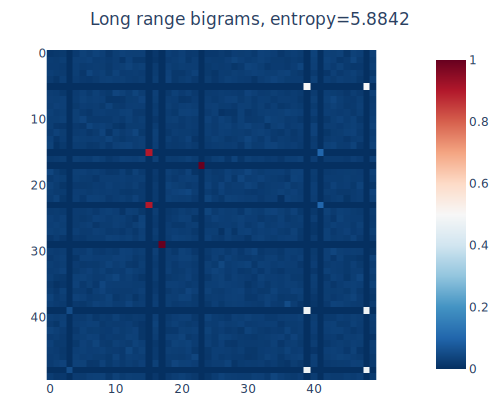

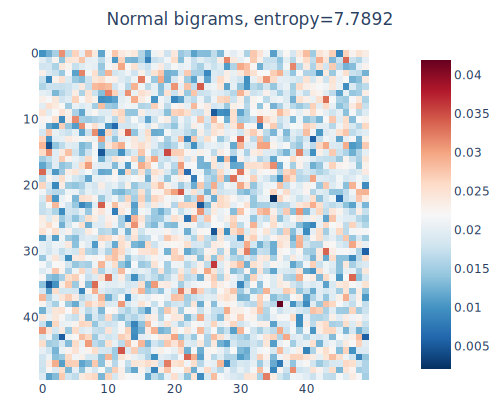

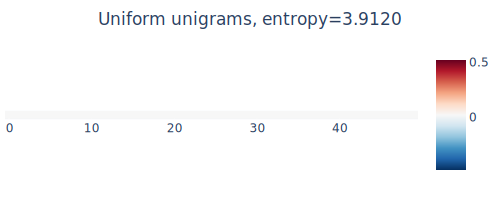

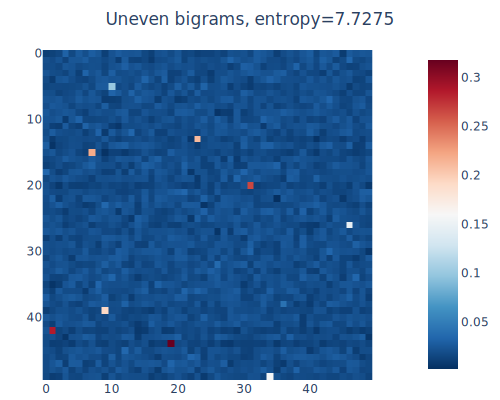

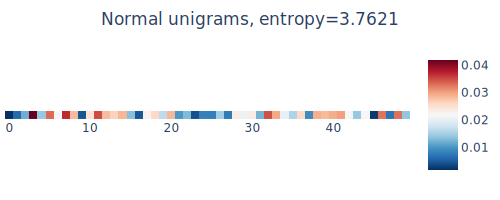

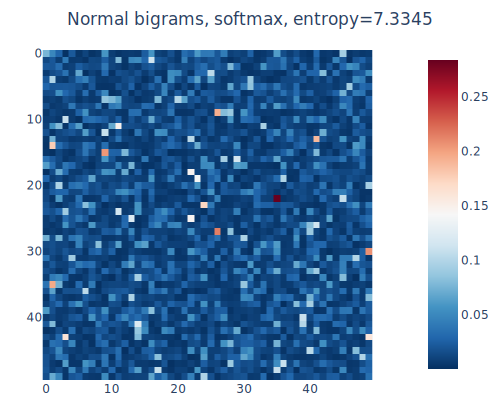

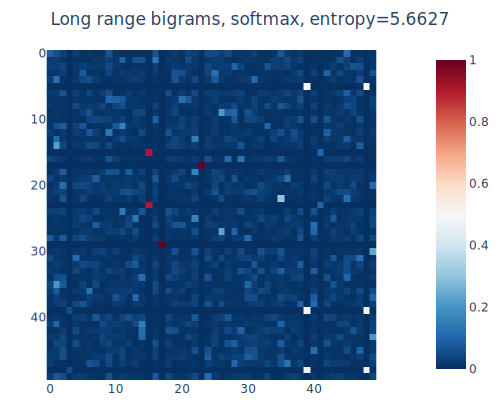

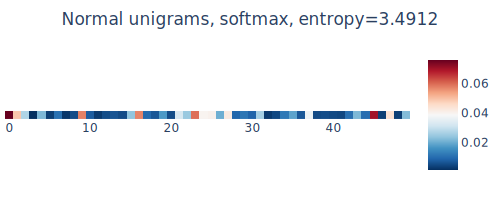

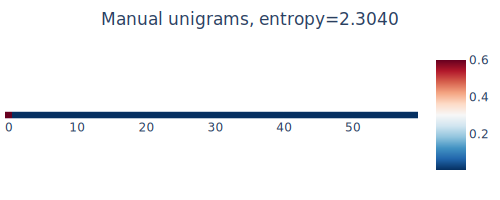

In [75]:
for fname, table, entropy in zip(fnames, tables, entropies):
    if 'unigrams' in fname:
        table = [table]
    plot_heatmap(fname, table, entropy)